# Data Preparation and Sampling
This notebook belongs to [this](https://medium.com/@timoboehm/movie-posters-81af5707e69a) blog post. Go there for details and background.

In [3]:
import re
import numpy as np
import pandas as pd

In [4]:
def read_and_clean_data(path):
    df = pd.read_csv(path, encoding="ISO-8859-1", usecols=["imdbId", "Title","Score","Genre", "Poster"])
    df.set_index(["imdbId"], inplace=True)
    print(f"Shape of the original dataset: {df.shape}")
    df.dropna(inplace=True)
    print(f"Shape after dropping rows with missing values: {df.shape}")
    df.drop_duplicates(subset="Poster", keep=False, inplace=True)
    print(f"Shape after dropping rows with potentially misleading poster link: {df.shape}\n")
    return df

In [5]:
def add_year_variable(df):
    re_year = re.compile("\((\d{4})\)")
    df["year"] = df.Title.map(lambda x: int(re_year.findall(x)[0]) if re_year.findall(x) else None)
    print(f"There are movies between {int(np.min(df.year))} and {int(np.max(df.year))} available in the dataset.\n")
    print(f"Shape after adding years: {df.shape}\n")
    return df

In [6]:
def create_boolean_genres(df):
    df["Genre"] = df.Genre.map(lambda x: x.split("|"))
    all_genres = set([item for l in df.Genre for item in l])
    print(f"There are {len(all_genres)} genres in the dataset: {all_genres}\n")
    for genre in all_genres:
        new_var = "is_" + re.sub(r'\W+', '', genre.lower())
        df[new_var] = df.Genre.map(lambda x: genre in x).astype(int)
    return df

In [7]:
def extract_genre_data(df, genre="Action"):
    filter_var = "is_" + re.sub(r'\W+', '', genre.lower())
    df_genre = df.copy().loc[df[filter_var]]
    print(f"{genre} movies in the dataset: {df_genre.shape[0]}\n")
    return df_genre

In [8]:
def select_years(df, min_year=1950, max_year=2000, add_decades=True):
    df_range = df.copy().loc[(df.year >= min_year) & (df.year < max_year)]
    print(f"Movies left between {min_year} and {max_year}: {df_range.shape[0]}")
    if add_decades:
        df_range["decade"] = df_range.year.apply(lambda x: str(int(x))[2] +"0s")
        print(f"Movies per decade in the dataset:\n{df_range.decade.value_counts()}\n")
    return df_range

In [9]:
def sample_same_number_per_decade(df, use_test_sample=False):
    min_number = 40 if use_test_sample else np.min(df.decade.value_counts())
    df_sample = df.groupby("decade").apply(lambda x: x.sample(min_number))
    print(f"Sample includes {min_number} movies per decade")
    return df_sample
def f(row):
    if row['Score'] >=0 and row['Score'] <= 4:
        val = 0
    elif row['Score'] >=5 and row['Score'] <=7:
        val = 1
    else:
        val = 2
    return val

In [10]:
movie_data = read_and_clean_data(path="./data/MovieGenre.csv")
movie_data = add_year_variable(movie_data)
movie_data = create_boolean_genres(movie_data)

genre_movies = movie_data.loc[movie_data['is_horror'] == 1]
non_genre_movies = movie_data.loc[movie_data['is_horror'] == 0]
sampled_movies = non_genre_movies.sample(n = 3800)
data_set = pd.concat([genre_movies,sampled_movies])

afterNF = (movie_data.year >= 1995).astype(int)

movie_data["afterNF"] = afterNF

movie_data['ratingClass']= movie_data.apply(f,axis=1)        

Shape of the original dataset: (40108, 4)
Shape after dropping rows with missing values: (39246, 4)
Shape after dropping rows with potentially misleading poster link: (37833, 4)

There are movies between 1874 and 2017 available in the dataset.

Shape after adding years: (37833, 5)

There are 28 genres in the dataset: {'Mystery', 'Drama', 'Thriller', 'Animation', 'Game-Show', 'Talk-Show', 'Musical', 'Adult', 'Documentary', 'Horror', 'Reality-TV', 'News', 'Crime', 'History', 'Western', 'Adventure', 'Music', 'Romance', 'Biography', 'Film-Noir', 'Comedy', 'Sport', 'Sci-Fi', 'Fantasy', 'Action', 'War', 'Short', 'Family'}



# Download Posters in correct File Structure

In [41]:
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import urllib.request
from urllib.error import HTTPError

import PIL

In [42]:
def create_train_and_test_dfs(df, prop_test=.2):
    df.dropna(inplace=True)
    train, test = train_test_split(df, test_size=prop_test, stratify=df.afterNF)
    print(f"Number of movies in training data: {train.shape[0]}")
    print(f"Number of movies in testing data:  {test.shape[0]}\n")
    return {"train": train, "test": test}

In [43]:
def create_folder_structure(image_folder="movie_posters", splits=["train", "test"], classes=None):
    for s in splits:
        for c in classes:
            folder_name = "\\".join([image_folder, s, c])
            try:
                os.makedirs(folder_name)
            except FileExistsError:
                print(f"{folder_name} already exists.")
        print("\n")

In [44]:
def download_posters(dfs, image_folder="movie_posters"):
    for k, df in dfs.items():
        print(f"Starting with downloading files for {k}...\n")
        already_downloaded = 0
        http_errors = []
        for index, movie in df.iterrows():
            movie_id = str(index[1])
            movie_decade = index[0]
            file_name = movie_id + ".jpg"
            file_path = "\\".join([image_folder, k, movie_decade, file_name])
            if os.path.isfile(file_path):
                already_downloaded += 1
            else:
                try:
                    urllib.request.urlretrieve(movie.Poster, file_path)       
                except HTTPError:
                    http_errors.append(movie_id)
        print(f"{len(http_errors)} posters had an HTTPError.")
        print(f"{already_downloaded} posters were downloaded before.\n")
        count = 0
        for root, dirs, files in os.walk("\\".join([image_folder, k])):
            if len(dirs) == 0:
                count += len(files)
                print(f"Number of pictures in {root}:\t{len(files)}")
        print(f"\nTotal number of pictures available for {k}: {count}\n")

In [45]:
def delete_black_and_white_posters(image_folder=None):
    print(f"\nChecking for black and white pictures in {image_folder}...")
    count = 0
    for root, dirs, files in os.walk(image_folder):
        if len(files) > 0:
            for f in files:
                file_path = "\\".join([root, f])
                if np.asarray(PIL.Image.open(file_path)).shape != (268, 182, 3):
                    os.remove(file_path)
                    count += 1
    print(f"Files without RGB and therefore deleted: {count}")

In [46]:
image_folder = "movie_posters"
dfs = create_train_and_test_dfs(movie_data)
train = dfs["train"]
test = dfs["test"]

Number of movies in training data: 29892
Number of movies in testing data:  7474



In [47]:

feature_columns = ["Score","year"]
label_columns = ["is_horror"]
xtrain = train[feature_columns]
xtest = test[feature_columns]
ytrain =train[label_columns]
ytest= test[label_columns]


In [48]:
logreg = LogisticRegression(solver='lbfgs', multi_class='multinomial',class_weight='balanced')
logreg.fit(xtrain,ytrain.values.ravel())
ypred = logreg.predict(xtest)

In [49]:
cnf = metrics.confusion_matrix(ytest,ypred)
cnf

array([[4909, 1764],
       [ 258,  543]], dtype=int64)

In [50]:
print("Accuracy:",metrics.accuracy_score(ytest, ypred))

Accuracy: 0.7294621354027294


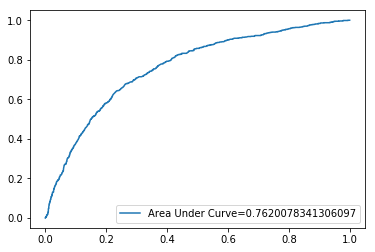

In [52]:
y_pred_proba = logreg.predict_proba(xtest)[::,1]
fpr, tpr, _ = metrics.roc_curve(ytest,  y_pred_proba)
auc = metrics.roc_auc_score(ytest, y_pred_proba)
plt.plot(fpr,tpr,label="Area Under Curve="+str(auc))
plt.legend(loc=4)
plt.show()